# Sales prediciton:
    Predict sale of each particular product at every store

In [22]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [23]:
# load in the data
big_mart_df_raw = pd.read_csv('./data.csv')

In [24]:
from sklearn.cross_validation import KFold
eval_size = 0.10
kf = KFold(len(big_mart_df_raw['Item_Outlet_Sales']), round(1./eval_size))
train_idx, val_idx = next(iter(kf))
train_idx_lst = train_idx.tolist()
val_idx_lst = val_idx.tolist()
big_mart_df = big_mart_df_raw.loc[train_idx_lst]
big_mart_df_val = big_mart_df_raw.loc[val_idx_lst]

## We do not use the big_mart_df_val data set , we only use it at the very end for validation of our model

In [25]:
# an item can be sold among all stores
big_mart_df[big_mart_df.Item_Identifier == 'FDA15']

Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility Item_Type  \
2599           FDA15          9.3          Low Fat         0.016019     Dairy   
2643           FDA15          9.3          Low Fat         0.016088     Dairy   
4874           FDA15          9.3          Low Fat         0.026818     Dairy   
5413           FDA15          9.3          Low Fat         0.016009     Dairy   
6696           FDA15          NaN          Low Fat         0.015945     Dairy   
7543           FDA15          9.3               LF         0.016113     Dairy   

      Item_MRP Outlet_Identifier  Outlet_Establishment_Year Outlet_Size  \
2599  248.5092            OUT035                       2004       Small   
2643  249.6092            OUT018                       2009      Medium   
4874  248.9092            OUT010                       1998         NaN   
5413  250.6092            OUT013                       1987        High   
6696  249.5092            OUT027                       1985      Medium   
7543  248.8092            OUT017                       2007         NaN   

     Outlet_Location_Type        Outlet_Type  Item_Outlet_Sales  
2599               Tier 2  Supermarket Type1          6474.2392  
2643               Tier 3  Supermarket Type2          5976.2208  
4874               Tier 3      Grocery Store           498.0184  
5413               Tier 3  Supermarket Type1          6474.2392  
6696               Tier 3  Supermarket Type3          6474.2392  
7543               Tier 2  Supermarket Type1          5976.2208

In [26]:
big_mart_df.head()

Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
853           FDJ40          NaN          Regular         0.049349   
854           FDU13          NaN          low fat         0.328391   
855           DRE27       11.850          Low Fat         0.132671   
856           FDS27       10.195          Regular         0.012456   
857           FDU44          NaN          Regular         0.058143   

                 Item_Type  Item_MRP Outlet_Identifier  \
853           Frozen Foods  108.6912            OUT027   
854                 Canned  146.0418            OUT019   
855                  Dairy   96.4726            OUT046   
856                   Meat  197.5110            OUT035   
857  Fruits and Vegetables  162.1552            OUT027   

     Outlet_Establishment_Year Outlet_Size Outlet_Location_Type  \
853                       1985      Medium               Tier 3   
854                       1985       Small               Tier 1   
855                       1997       Small               Tier 1   
856                       2004       Small               Tier 2   
857                       1985      Medium               Tier 3   

           Outlet_Type  Item_Outlet_Sales  
853  Supermarket Type3          3057.3536  
854      Grocery Store           588.5672  
855  Supermarket Type1           978.7260  
856  Supermarket Type1          2356.9320  
857  Supermarket Type3          3086.6488

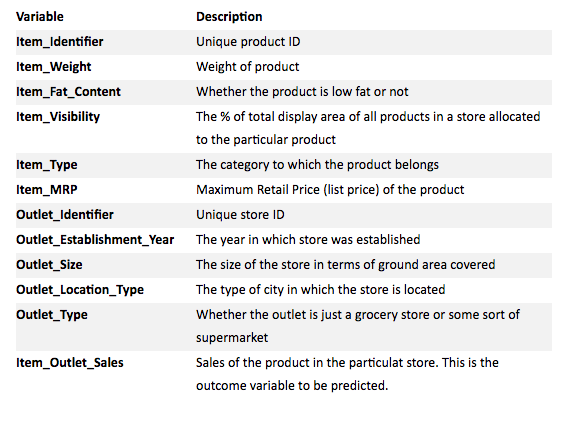

# Data Exploration and preparation:

In [27]:
# 1. Know the data types
big_mart_df.describe()

Item_Weight  Item_Visibility     Item_MRP  Outlet_Establishment_Year  \
count  6363.000000      7670.000000  7670.000000                7670.000000   
mean     12.839341         0.066258   141.231646                1997.876662   
std       4.637560         0.051589    62.235136                   8.370210   
min       4.555000         0.000000    31.490000                1985.000000   
25%       8.775000         0.027077    94.184400                1987.000000   
50%      12.600000         0.054036   143.215400                1999.000000   
75%      16.750000         0.094956   185.782550                2004.000000   
max      21.350000         0.328391   266.888400                2009.000000   

       Item_Outlet_Sales  
count        7670.000000  
mean         2176.067821  
std          1700.873724  
min            33.290000  
25%           834.913200  
50%          1794.331000  
75%          3094.638400  
max         13086.964800

In [28]:
big_mart_df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

In [29]:
# 2. univariate Analysis
from scipy.stats.mstats import mode
def get_descriptive_stats_continuous(input_df, column):
    """
    Function to print the descriptive statics of a give dataframe
    
    @Params:
        input_df: the input data frame which contains a column whose descriptive statics is to be calculated
        column: the name of the column whose descriptive statics is to be calculated.
        
    @Returns:
        desc_stat: a dictionary with the descriptive statistics
    """
    KEY_ORDER = ['count', 'min', 'max', 'mean', 'median','mode', 'std', 'variance', '25%', '50%', '75%', 'NaN_count', 'NaN_perc']
    desc_stat = {}
    desc_stat = input_df[column].describe().to_dict()
    desc_stat['variance'] = input_df[column].var()
    desc_stat['median'] = input_df[column].median()
    desc_stat['mode'] = mode(input_df[column])[0][0]
    desc_stat['NaN_count'] = input_df[column].isnull().sum() 
    desc_stat['NaN_perc'] = str(input_df[column].isnull().sum() / desc_stat['count']) + '%'
    print('---------------------DESCRIPTIVE STATICS '+column+' ---------------------')
    for key in KEY_ORDER:
        
        print(key +': '+str(desc_stat[key]) )
    print('-------------------------------------------------------------')
    return desc_stat

In [32]:
def get_histogram_box_plots(input_df, column):
    plt.subplots(1, 1, figsize=(8, 4))
    plt.hist(input_df[input_df[column].notnull()][column])
    plt.title(column +' Histogram')
    plt.xlabel('value')
    plt.ylabel('frequency')
    plt.subplots(1, 1, figsize=(8, 4))
    plt.boxplot(input_df[input_df[column].notnull()][column].values)
    plt.title(column +' Box Plot')
    plt.show()

In [33]:
def get_continuous_univariate_analysis(input_df, column):
    get_descriptive_stats_continuous(input_df, column)
    print('-------------------------------------------------------------')
    get_histogram_box_plots(input_df, column)

---------------------DESCRIPTIVE STATICS Item_Weight ---------------------
count: 6363.0
min: 4.555
max: 21.35
mean: 12.8393407198
median: 12.6
mode: 12.15
std: 4.63756040962
variance: 21.506966552863744
25%: 8.775
50%: 12.6
75%: 16.75
NaN_count: 1307
NaN_perc: 0.205406254911%
-------------------------------------------------------------
-------------------------------------------------------------


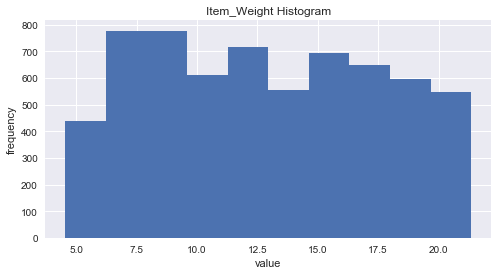

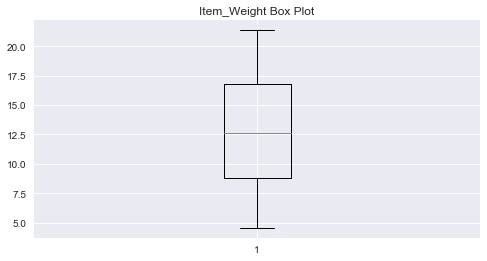

In [34]:
get_continuous_univariate_analysis(big_mart_df, 'Item_Weight')

In [35]:
# analysis for categorical values
def get_discrete_univariate_analysis(input_df, column):
    print('-------------'+column.upper()+'  DISTRIBUTION-----------------')
    rolled_up_df = input_df.groupby(column).size().reset_index(name='count').sort_values(['count'], ascending=False)
    count = rolled_up_df['count'].sum()
    rolled_up_df['perc'] = round((rolled_up_df['count'] / count) * 100, 2)
    rolled_up_df.index = range(1,len(rolled_up_df)+1)
    print(rolled_up_df)
    print('-------------------------------------------------------------')

In [36]:
get_discrete_univariate_analysis(big_mart_df, 'Item_Type')

-------------ITEM_TYPE  DISTRIBUTION-----------------
                Item_Type  count   perc
1   Fruits and Vegetables   1102  14.37
2             Snack Foods   1087  14.17
3               Household    819  10.68
4            Frozen Foods    769  10.03
5                   Dairy    603   7.86
6            Baking Goods    592   7.72
7                  Canned    579   7.55
8      Health and Hygiene    477   6.22
9             Soft Drinks    399   5.20
10                   Meat    375   4.89
11                 Breads    230   3.00
12            Hard Drinks    195   2.54
13                 Others    151   1.97
14          Starchy Foods    134   1.75
15              Breakfast     97   1.26
16                Seafood     61   0.80
-------------------------------------------------------------


# Do univariate analysis for all the columns:

In [37]:
big_mart_df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

In [38]:
# discrete columns
# Item_Identifier is not here because it is a unique item identifier
# Outlet_Establishment_Year is in discrete columns list because it will only have a limited set of values, pandas
# recognizes it as a float
dis_col = ['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type',
          'Outlet_Type', 'Outlet_Establishment_Year']
# continuous columns
cont_col = ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Item_Outlet_Sales']

# Univariate analysis for discrete colums:

In [39]:
for dis in dis_col:
    get_discrete_univariate_analysis(big_mart_df, dis)

-------------ITEM_FAT_CONTENT  DISTRIBUTION-----------------
  Item_Fat_Content  count   perc
1          Low Fat   4561  59.47
2          Regular   2608  34.00
3               LF    293   3.82
4              reg    107   1.40
5          low fat    101   1.32
-------------------------------------------------------------
-------------ITEM_TYPE  DISTRIBUTION-----------------
                Item_Type  count   perc
1   Fruits and Vegetables   1102  14.37
2             Snack Foods   1087  14.17
3               Household    819  10.68
4            Frozen Foods    769  10.03
5                   Dairy    603   7.86
6            Baking Goods    592   7.72
7                  Canned    579   7.55
8      Health and Hygiene    477   6.22
9             Soft Drinks    399   5.20
10                   Meat    375   4.89
11                 Breads    230   3.00
12            Hard Drinks    195   2.54
13                 Others    151   1.97
14          Starchy Foods    134   1.75
15              Breakfast

### notes:
    convert cases in Item_Fat_content, there is only 2 categories in this column Low Fat and Regular and some short hand notations of these.

In [40]:
# convert LF to Low Fat, reg to Regular and low fat to Low Fat
big_mart_df.Item_Fat_Content[big_mart_df.Item_Fat_Content == 'LF'] = 'Low Fat'
big_mart_df.Item_Fat_Content[big_mart_df.Item_Fat_Content == 'reg'] = 'Regular'
big_mart_df.Item_Fat_Content[big_mart_df.Item_Fat_Content == 'low fat'] = 'Low Fat'

/Users/Kevin/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/Kevin/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/Kevin/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Univariate analysis for continuous colums:

---------------------DESCRIPTIVE STATICS Item_Weight ---------------------
count: 6363.0
min: 4.555
max: 21.35
mean: 12.8393407198
median: 12.6
mode: 12.15
std: 4.63756040962
variance: 21.506966552863744
25%: 8.775
50%: 12.6
75%: 16.75
NaN_count: 1307
NaN_perc: 0.205406254911%
-------------------------------------------------------------
-------------------------------------------------------------


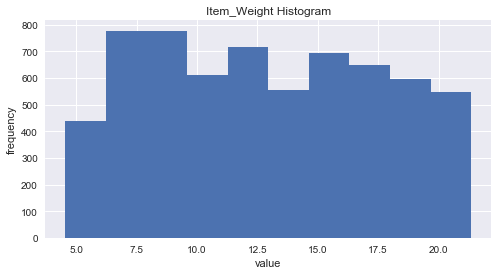

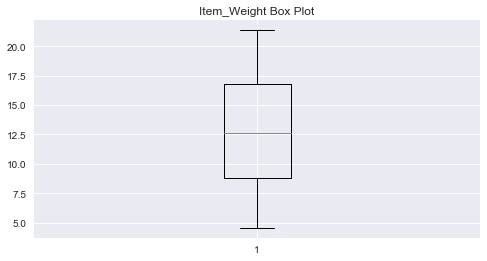

---------------------DESCRIPTIVE STATICS Item_Visibility ---------------------
count: 7670.0
min: 0.0
max: 0.328390948
mean: 0.0662579056492
median: 0.054036175
mode: 0.0
std: 0.051589459353
variance: 0.0026614723163303224
25%: 0.02707740925
50%: 0.054036175
75%: 0.09495591125
NaN_count: 0
NaN_perc: 0.0%
-------------------------------------------------------------
-------------------------------------------------------------


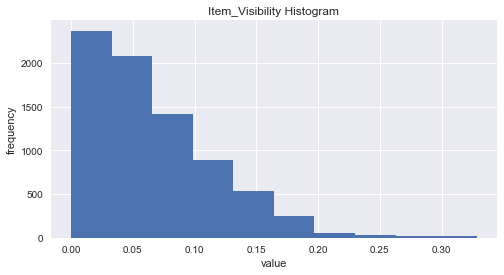

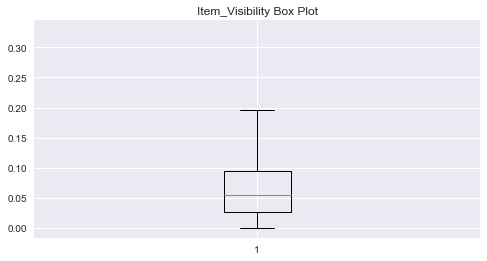

---------------------DESCRIPTIVE STATICS Item_MRP ---------------------
count: 7670.0
min: 31.49
max: 266.8884
mean: 141.231645502
median: 143.2154
mode: 172.0422
std: 62.2351364179
variance: 3873.2122049584445
25%: 94.1844
50%: 143.2154
75%: 185.78255
NaN_count: 0
NaN_perc: 0.0%
-------------------------------------------------------------
-------------------------------------------------------------


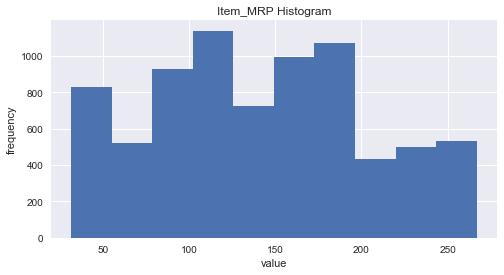

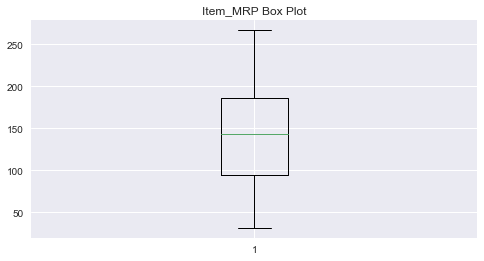

---------------------DESCRIPTIVE STATICS Item_Outlet_Sales ---------------------
count: 7670.0
min: 33.29
max: 13086.9648
mean: 2176.06782063
median: 1794.3310000000001
mode: 958.752
std: 1700.87372422
variance: 2892971.4257581364
25%: 834.9132
50%: 1794.331
75%: 3094.6384
NaN_count: 0
NaN_perc: 0.0%
-------------------------------------------------------------
-------------------------------------------------------------


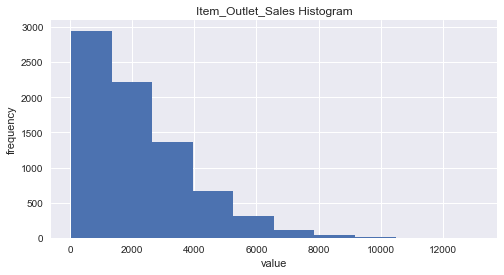

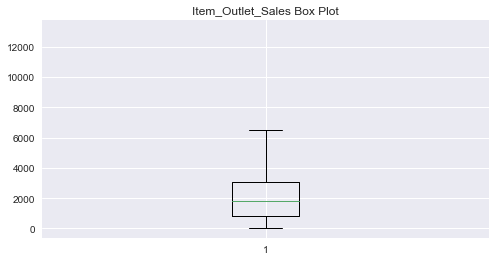

In [41]:
for cont in cont_col:
    get_continuous_univariate_analysis(big_mart_df, cont)

Note that the descriptive statistics are based on data across entire portfolio, not just one outlet.

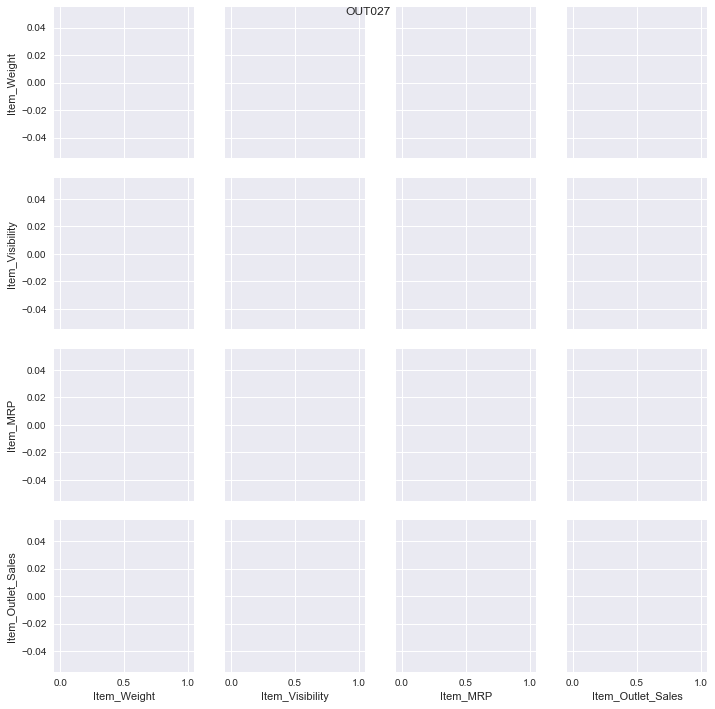

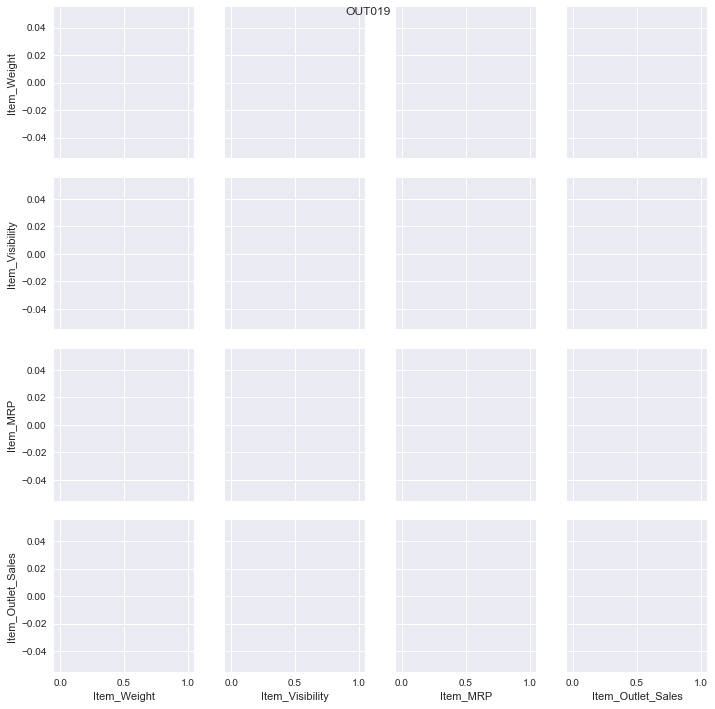

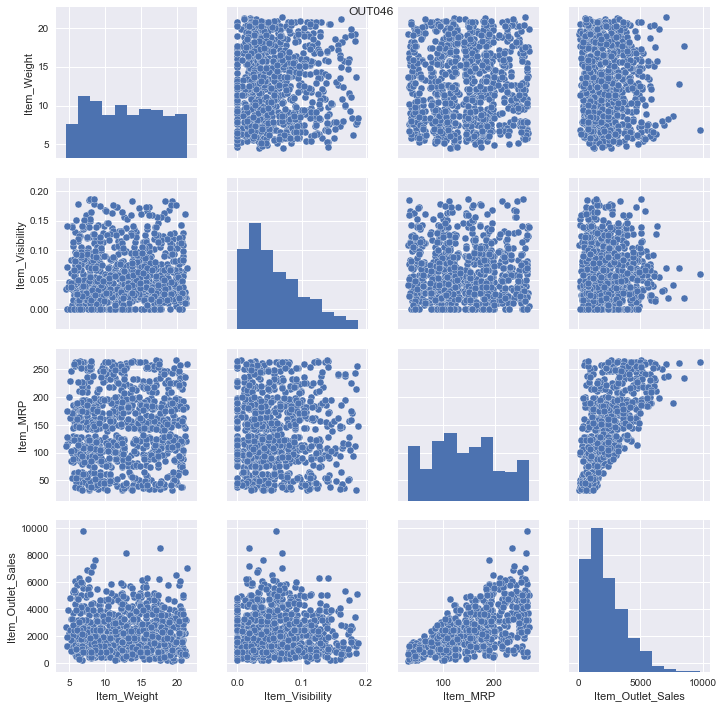

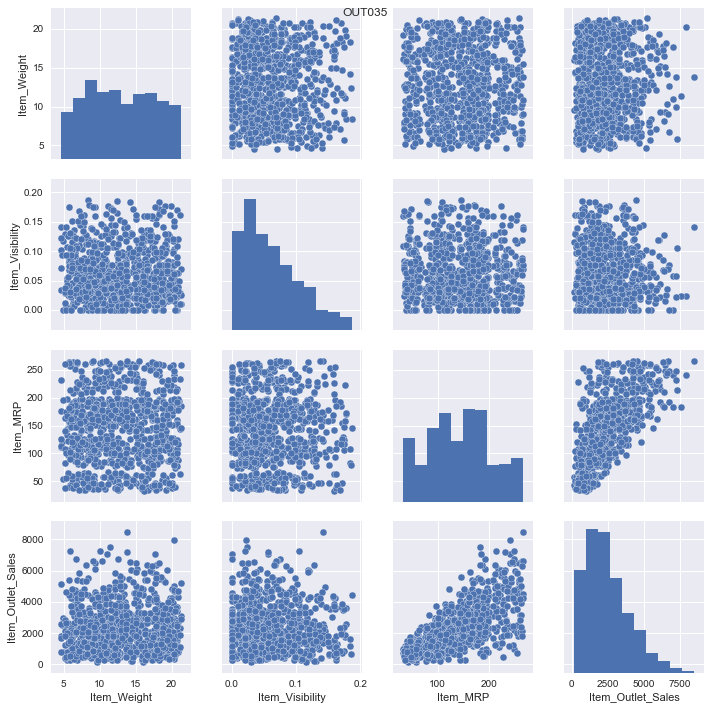

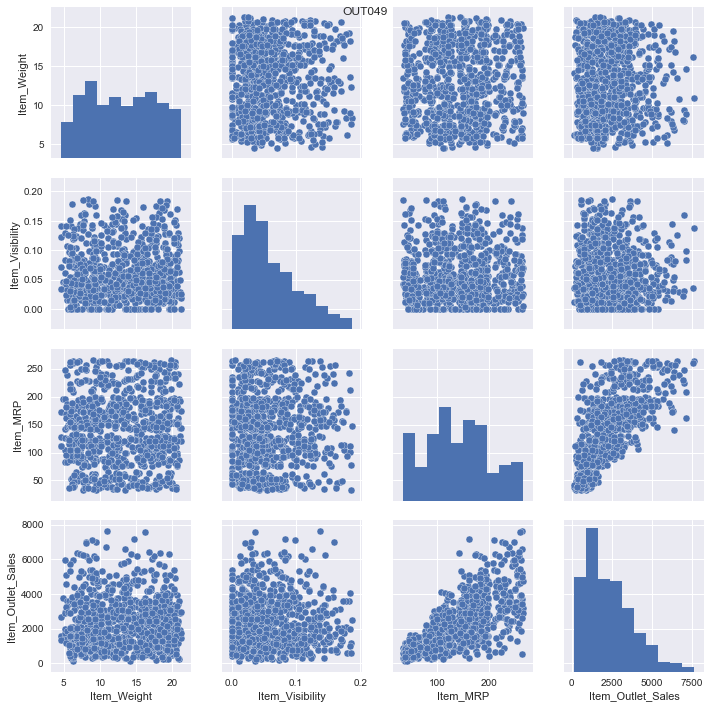

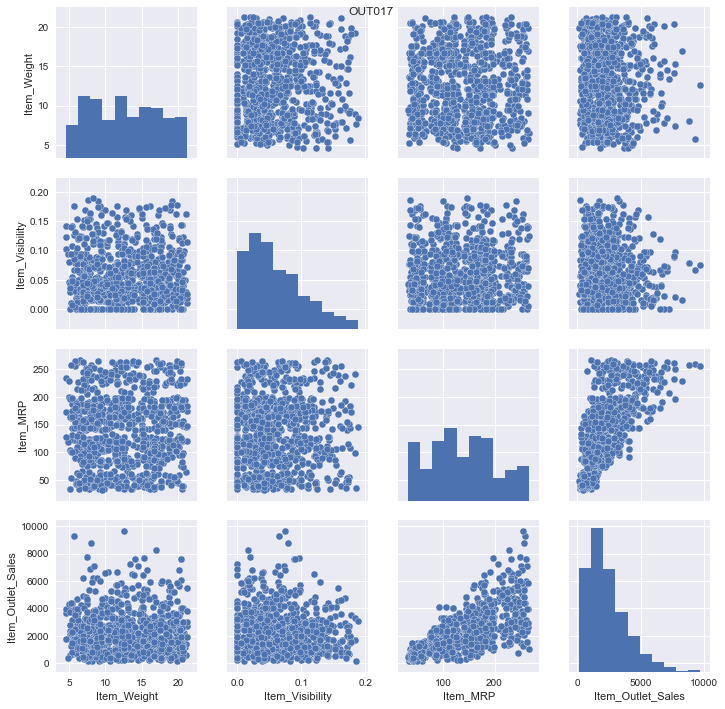

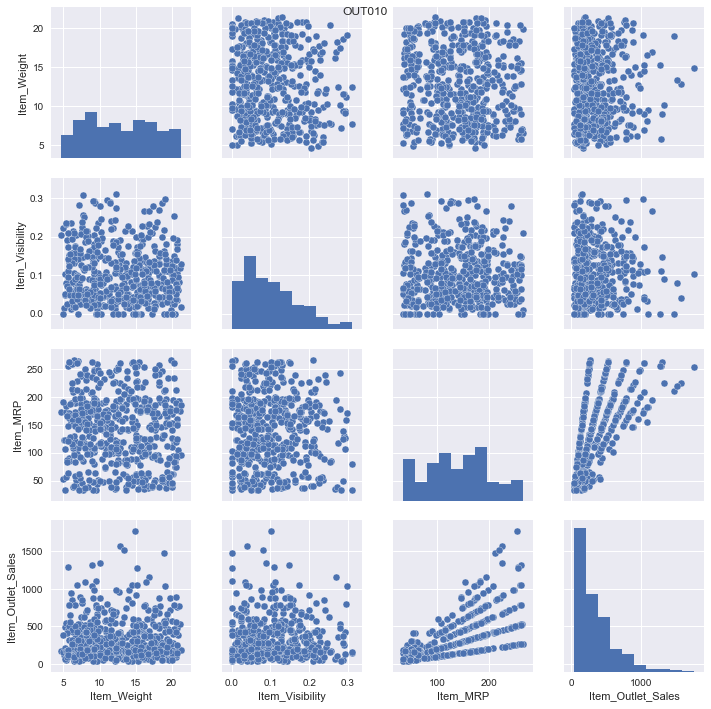

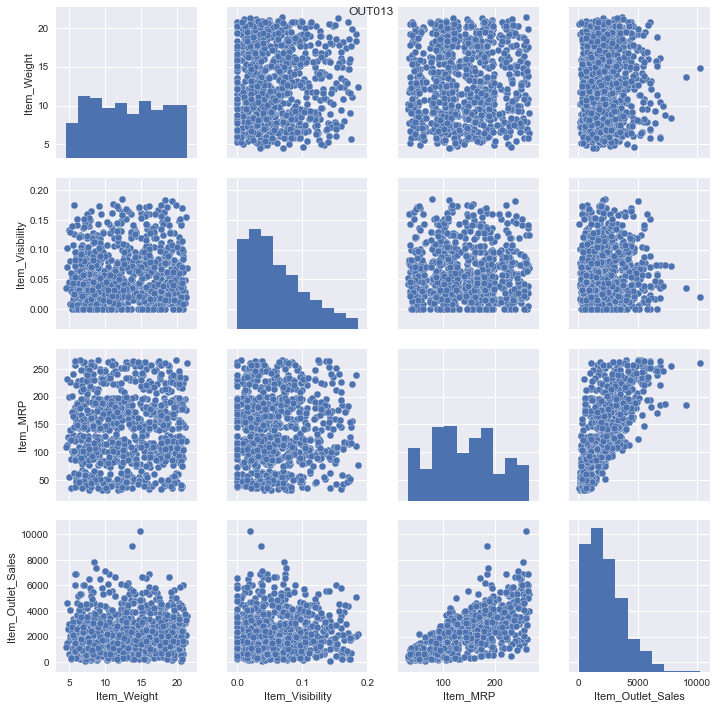

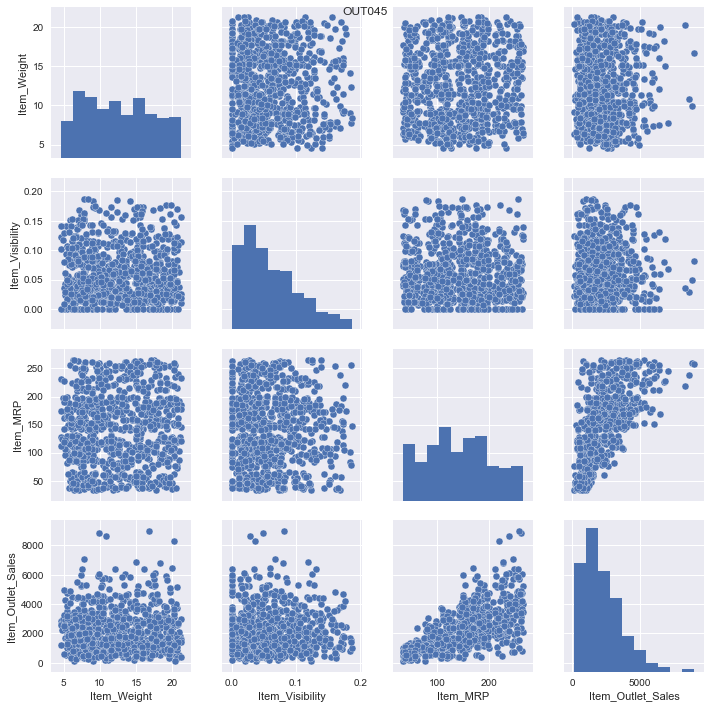

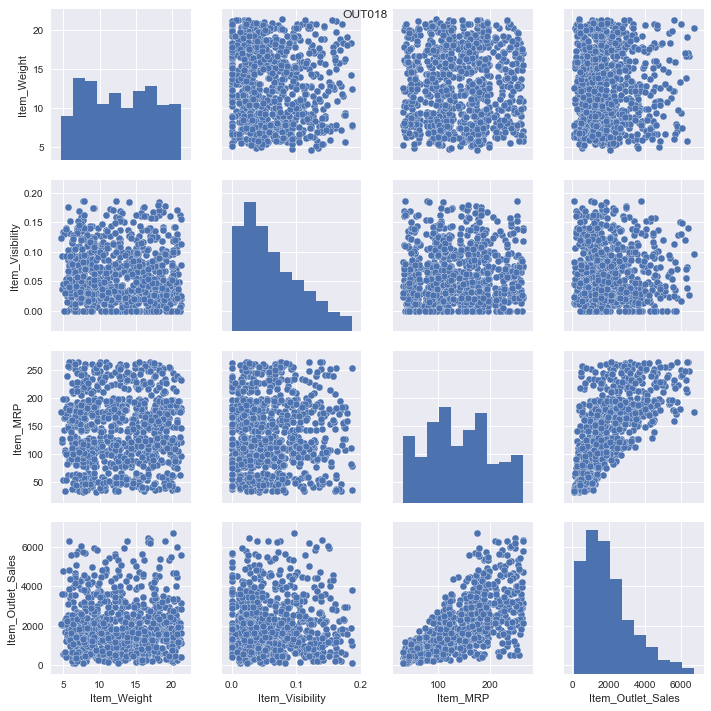

In [42]:
# Bivariate analysis
# we look at the scatter plots across the continuous variables
# it is better to look on an Outlet level
for outlet in big_mart_df['Outlet_Identifier'].unique().tolist():
    sns.pairplot(big_mart_df[big_mart_df.Outlet_Identifier == outlet][cont_col].dropna())
    plt.suptitle(outlet)

Some outlets are empty because they have NaN's, we will revisit this after missing value Imputation

In [43]:
# there is no clear visible correlation, we have to get the correlation coefficient between the columns
# correlation will be between -1 and 1
big_mart_df[cont_col].corr(method='pearson')

Item_Weight  Item_Visibility  Item_MRP  Item_Outlet_Sales
Item_Weight           1.000000        -0.016297  0.019829           0.010602
Item_Visibility      -0.016297         1.000000 -0.002602          -0.132546
Item_MRP              0.019829        -0.002602  1.000000           0.565186
Item_Outlet_Sales     0.010602        -0.132546  0.565186           1.000000

We see 
1. a high correlation between MRP and sales
2. as item visibility increases the outlet sales goes down, which is interesting because the common assumption would be that the higher the visibility the higher the sales.

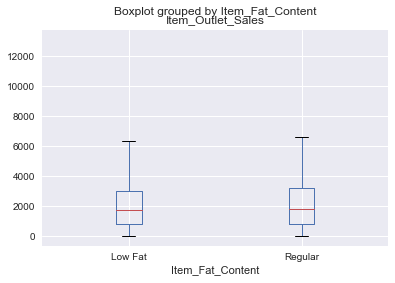

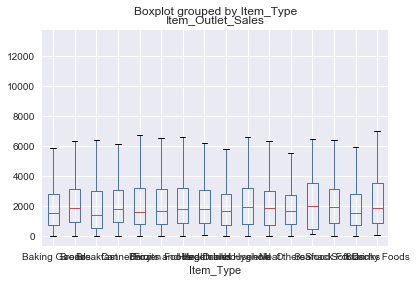

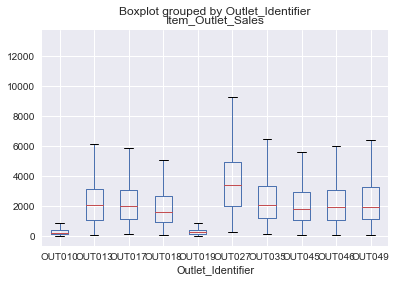

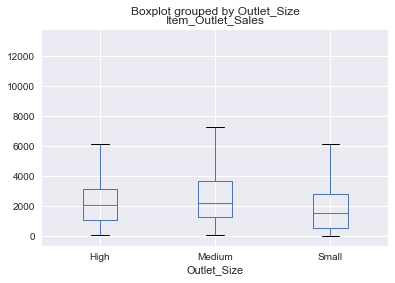

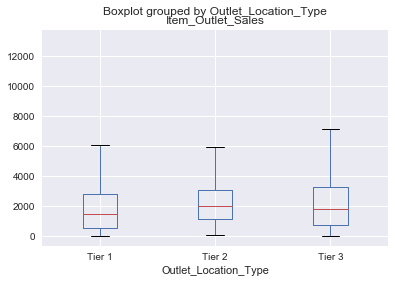

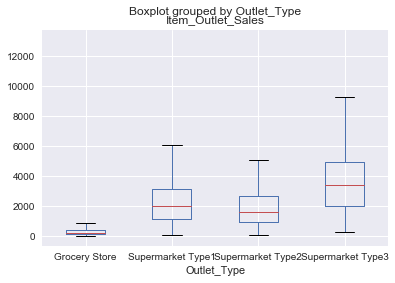

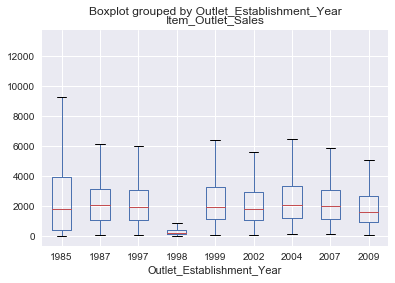

In [44]:
# we look at box plot of categorical variables against the continuous output variable
for dc in dis_col:
    big_mart_df.boxplot(column='Item_Outlet_Sales', by=dc)

In [45]:
# from visual inspection we can see the variables that may have statistically different means are 'Outlet_Identifier',
# 'Outlet_Type' and 'Outlet_Establishment_Year', for these lets use one way ANOVA to determine if our visual hypothesis is 
# correct.
from scipy.stats import f_oneway

In [46]:
# function to calculate one way ANOVA
def get_one_way_ANOVA(input_raw_df, discrete_column, continuous_column):
    # remove NaN value
    input_df = input_raw_df[[discrete_column, continuous_column]]
    input_df.dropna(inplace=True)
    # get the unique groups in the discrete column
    groups = input_df[discrete_column].unique().tolist()
    # get the individual groups as a list
    df_list = []
    for group in groups:
        df_list.append(input_df[input_df[discrete_column] == group][continuous_column])
    print('----------------------------'+discrete_column+'---------------------------------------------')
    anova_result = f_oneway(*df_list)
    print('F-Statistic: '+str(anova_result[0]))
    print('p_value: '+str(anova_result[1]))
    if anova_result[1] <= 0.05:
        print('The p value is less than 0.05 so we can reject the NULL hypothesis, which means population average of the different groups are different')
    else:
        print('The p value is greater than 0.05, we cannont reject NULL hypothesis, which means population average of the different groups are the same')
    print('------------------------------------------------------------------------------------------')

### Note if p <= 0.05 we can reject the null hypothesis (i.e the means are the same)
### A large p-value (> 0.05) indicates weak evidence against the null hypothesis, so you fail to reject the null hypothesis.
### p-values very close to the cutoff (0.05) are considered to be marginal (could go either way). Always report the p-value so your readers can draw their own conclusions.



In [47]:
multi_group_variables = ['Outlet_Identifier','Outlet_Type','Outlet_Establishment_Year']
target = 'Item_Outlet_Sales'
for col in multi_group_variables:
    get_one_way_ANOVA(big_mart_df, col, target)

----------------------------Outlet_Identifier---------------------------------------------
F-Statistic: 274.933248429
p_value: 0.0
The p value is less than 0.05 so we can reject the NULL hypothesis, which means population average of the different groups are different
------------------------------------------------------------------------------------------
----------------------------Outlet_Type---------------------------------------------
F-Statistic: 819.864272453
p_value: 0.0
The p value is less than 0.05 so we can reject the NULL hypothesis, which means population average of the different groups are different
------------------------------------------------------------------------------------------
----------------------------Outlet_Establishment_Year---------------------------------------------
F-Statistic: 93.8178029145
p_value: 2.22124007751e-149
The p value is less than 0.05 so we can reject the NULL hypothesis, which means population average of the different groups are differe

/Users/Kevin/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


This means that 
    1. different outlets have different sales, expected
    2. different types of outlets have different sales, expected
    3. the year of outlet establishment also has an effect on sales, not entirely expected
    
  We can do a post analysis of the columns to figure out which groups differ
  
  ref: http://hamelg.blogspot.com/2015/11/python-for-data-analysis-part-16_23.html

In [48]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
def get_tukey_test(input_df, discrete_column, continuous_column, alpha =0.05):
    print('-----------------------------------'+discrete_column+' Tukey Test --------------------------------')
    tukey = pairwise_tukeyhsd(endog=input_df[continuous_column],     # Data
                              groups=input_df[discrete_column],      # Groups
                              alpha=alpha)                           # Significance level
    
    print(tukey.summary())              # See test summary

In [49]:
multi_group_variables = ['Outlet_Identifier','Outlet_Type','Outlet_Establishment_Year']
target = 'Item_Outlet_Sales'
for col in multi_group_variables:
    get_tukey_test(big_mart_df, col, target)

-----------------------------------Outlet_Identifier Tukey Test --------------------------------
  Multiple Comparison of Means - Tukey HSD,FWER=0.05 
group1 group2  meandiff    lower      upper    reject
-----------------------------------------------------
OUT010 OUT013 1984.1827  1720.3291  2248.0364   True 
OUT010 OUT017 1994.4847  1731.1635   2257.806   True 
OUT010 OUT018 1644.5427  1381.3966  1907.6888   True 
OUT010 OUT019   3.1452    -295.515   301.8054  False 
OUT010 OUT027 3370.2518  3106.0978  3634.4057   True 
OUT010 OUT035 2096.9018   1833.286  2360.5175   True 
OUT010 OUT045 1848.0596  1583.3568  2112.7624   True 
OUT010 OUT046  1931.266  1667.1121   2195.42    True 
OUT010 OUT049 1985.4334  1722.3455  2248.5214   True 
OUT013 OUT017   10.302   -218.3836   238.9875  False 
OUT013 OUT018  -339.64   -568.1238  -111.1562   True 
OUT013 OUT019 -1981.0375 -2249.6579 -1712.4172  True 
OUT013 OUT027  1386.069  1156.4252  1615.7129   True 
OUT013 OUT035  112.719   -116.3056   34

# Treat missing values:
    1. We have identifiers and their corresponding values in other records, use them to fill the NaN values.

In [50]:
for dis in dis_col:
    nan_val_cnt = len(big_mart_df[pd.isnull(big_mart_df[dis])])
    print('Column: '+dis+' has '+str(nan_val_cnt)+' missing values')

Column: Item_Fat_Content has 0 missing values
Column: Item_Type has 0 missing values
Column: Outlet_Identifier has 0 missing values
Column: Outlet_Size has 2169 missing values
Column: Outlet_Location_Type has 0 missing values
Column: Outlet_Type has 0 missing values
Column: Outlet_Establishment_Year has 0 missing values


In [51]:
for cont in cont_col:
    nan_val_cnt = len(big_mart_df[pd.isnull(big_mart_df[cont])])
    print('Column: '+cont+' has '+str(nan_val_cnt)+' missing values')

Column: Item_Weight has 1307 missing values
Column: Item_Visibility has 0 missing values
Column: Item_MRP has 0 missing values
Column: Item_Outlet_Sales has 0 missing values


We have missing values in Outlet_Size and Item_weight columns.
    1. Item_Weight can be filled using other entries for that Item (use Item_Identifier)
    2. Outlet_size can be filled using other entries for that Outlet (use Outlet_Identifier)

In [52]:
# get unique combinations of Item_Identifier and Item_Weight as key value pairs
id_weight_df = big_mart_df[['Item_Identifier', 'Item_Weight']].drop_duplicates().dropna()
# get new df with filled item_weight columns
bd_df = pd.merge(left=big_mart_df.ix[:, big_mart_df.columns != 'Item_Weight']
, right=id_weight_df, left_on='Item_Identifier', right_on='Item_Identifier', how='left')
bd_df.head()

Item_Identifier Item_Fat_Content  Item_Visibility              Item_Type  \
0           FDJ40          Regular         0.049349           Frozen Foods   
1           FDU13          Low Fat         0.328391                 Canned   
2           DRE27          Low Fat         0.132671                  Dairy   
3           FDS27          Regular         0.012456                   Meat   
4           FDU44          Regular         0.058143  Fruits and Vegetables   

   Item_MRP Outlet_Identifier  Outlet_Establishment_Year Outlet_Size  \
0  108.6912            OUT027                       1985      Medium   
1  146.0418            OUT019                       1985       Small   
2   96.4726            OUT046                       1997       Small   
3  197.5110            OUT035                       2004       Small   
4  162.1552            OUT027                       1985      Medium   

  Outlet_Location_Type        Outlet_Type  Item_Outlet_Sales  Item_Weight  
0               Tier 3  Supermarket Type3          3057.3536       13.600  
1               Tier 1      Grocery Store           588.5672        8.355  
2               Tier 1  Supermarket Type1           978.7260       11.850  
3               Tier 2  Supermarket Type1          2356.9320       10.195  
4               Tier 3  Supermarket Type3          3086.6488       12.150

In [53]:
big_mart_df.describe()

Item_Weight  Item_Visibility     Item_MRP  Outlet_Establishment_Year  \
count  6363.000000      7670.000000  7670.000000                7670.000000   
mean     12.839341         0.066258   141.231646                1997.876662   
std       4.637560         0.051589    62.235136                   8.370210   
min       4.555000         0.000000    31.490000                1985.000000   
25%       8.775000         0.027077    94.184400                1987.000000   
50%      12.600000         0.054036   143.215400                1999.000000   
75%      16.750000         0.094956   185.782550                2004.000000   
max      21.350000         0.328391   266.888400                2009.000000   

       Item_Outlet_Sales  
count        7670.000000  
mean         2176.067821  
std          1700.873724  
min            33.290000  
25%           834.913200  
50%          1794.331000  
75%          3094.638400  
max         13086.964800

In [54]:
bd_df.describe()

Item_Visibility     Item_MRP  Outlet_Establishment_Year  \
count      7670.000000  7670.000000                7670.000000   
mean          0.066258   141.231646                1997.876662   
std           0.051589    62.235136                   8.370210   
min           0.000000    31.490000                1985.000000   
25%           0.027077    94.184400                1987.000000   
50%           0.054036   143.215400                1999.000000   
75%           0.094956   185.782550                2004.000000   
max           0.328391   266.888400                2009.000000   

       Item_Outlet_Sales  Item_Weight  
count        7670.000000  7665.000000  
mean         2176.067821    12.851251  
std          1700.873724     4.639454  
min            33.290000     4.555000  
25%           834.913200     8.775000  
50%          1794.331000    12.600000  
75%          3094.638400    16.850000  
max         13086.964800    21.350000

---------------------DESCRIPTIVE STATICS Item_Weight ---------------------
count: 7665.0
min: 4.555
max: 21.35
mean: 12.8512511416
median: 12.6
mode: 12.15
std: 4.63945392315
variance: 21.524532705056266
25%: 8.775
50%: 12.6
75%: 16.85
NaN_count: 5
NaN_perc: 0.000652315720809%
-------------------------------------------------------------
-------------------------------------------------------------


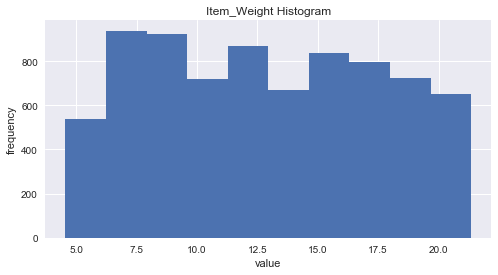

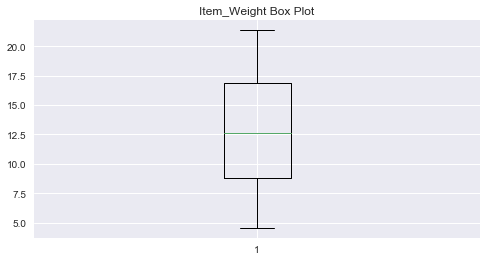

In [55]:
get_continuous_univariate_analysis(bd_df, 'Item_Weight')

We see that the now there are only 4 NaN's in the Item Weight column

Now repeat the process for Outlet Size

In [56]:
bd_df[['Outlet_Identifier', 'Outlet_Size']].drop_duplicates()

Outlet_Identifier Outlet_Size
0             OUT027      Medium
1             OUT019       Small
2             OUT046       Small
3             OUT035       Small
6             OUT049      Medium
7             OUT017         NaN
8             OUT010         NaN
10            OUT013        High
11            OUT045         NaN
21            OUT018      Medium

In [57]:
id_size_df = bd_df[['Outlet_Identifier', 'Outlet_Size']].drop_duplicates().dropna()

In [58]:
id_size_df

Outlet_Identifier Outlet_Size
0             OUT027      Medium
1             OUT019       Small
2             OUT046       Small
3             OUT035       Small
6             OUT049      Medium
10            OUT013        High
21            OUT018      Medium

In [59]:
bd_df['Outlet_Identifier'].unique()

array(['OUT027', 'OUT019', 'OUT046', 'OUT035', 'OUT049', 'OUT017',
       'OUT010', 'OUT013', 'OUT045', 'OUT018'], dtype=object)

Note that here we cannot use the same approach we used for Item Weight, because these Outlet_Identifiers dont have
Outlet_Size data for any records.

In [60]:
bd_df.columns

Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Visibility', 'Item_Type',
       'Item_MRP', 'Outlet_Identifier', 'Outlet_Establishment_Year',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type',
       'Item_Outlet_Sales', 'Item_Weight'],
      dtype='object')

In [61]:
# get the outlet variables
bd_df[['Outlet_Identifier', 'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']].drop_duplicates()

Outlet_Identifier  Outlet_Establishment_Year Outlet_Size  \
0             OUT027                       1985      Medium   
1             OUT019                       1985       Small   
2             OUT046                       1997       Small   
3             OUT035                       2004       Small   
6             OUT049                       1999      Medium   
7             OUT017                       2007         NaN   
8             OUT010                       1998         NaN   
10            OUT013                       1987        High   
11            OUT045                       2002         NaN   
21            OUT018                       2009      Medium   

   Outlet_Location_Type        Outlet_Type  
0                Tier 3  Supermarket Type3  
1                Tier 1      Grocery Store  
2                Tier 1  Supermarket Type1  
3                Tier 2  Supermarket Type1  
6                Tier 1  Supermarket Type1  
7                Tier 2  Supermarket Type1  
8                Tier 3      Grocery Store  
10               Tier 3  Supermarket Type1  
11               Tier 2  Supermarket Type1  
21               Tier 3  Supermarket Type2

We can approximate OUT045 and OUT017 are Small, from OUT035 which is very similar to the first two Outlets
OUT010 can be approximated as Small as well because it is a 'Grocery Store' and a 'Tier 3' city which means it might not be as big as a grocery store in a 'Tier 1' city.

## Note: this is an assumption which can be revisited if our model doesnt perform well

In [62]:
# fill Outlet_Size NaN's with 'Small'
bd_df['Outlet_Size'].fillna('Small', inplace=True)

In [63]:
bd_df[['Outlet_Identifier', 'Outlet_Size']].drop_duplicates()

Outlet_Identifier Outlet_Size
0             OUT027      Medium
1             OUT019       Small
2             OUT046       Small
3             OUT035       Small
6             OUT049      Medium
7             OUT017       Small
8             OUT010       Small
10            OUT013        High
11            OUT045       Small
21            OUT018      Medium

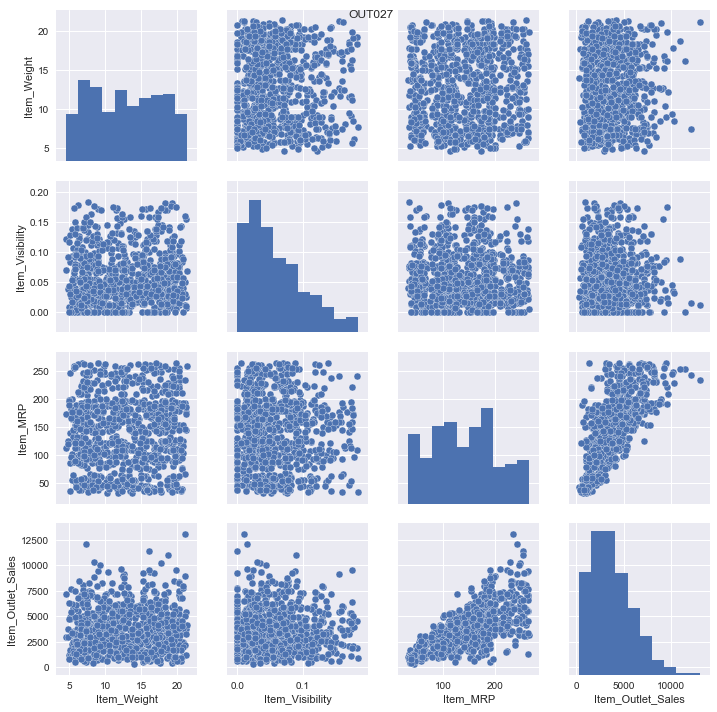

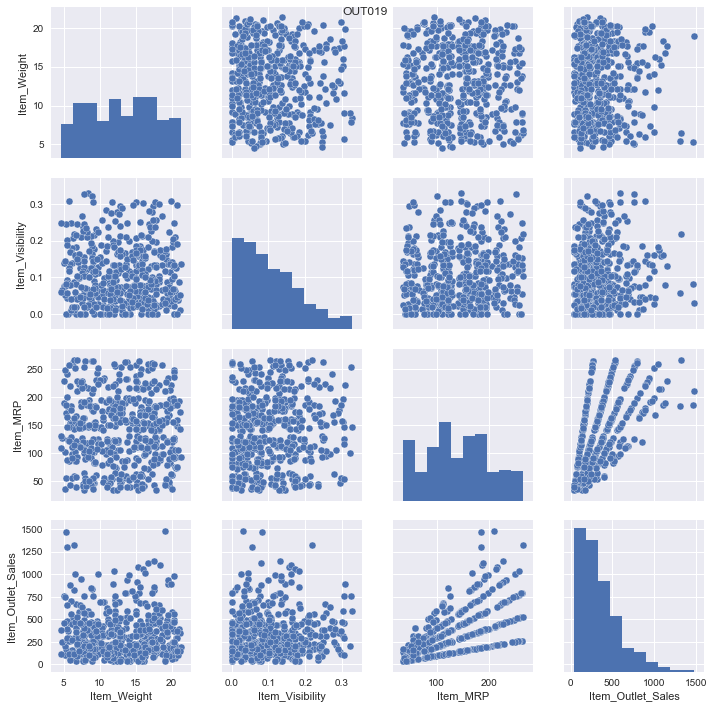

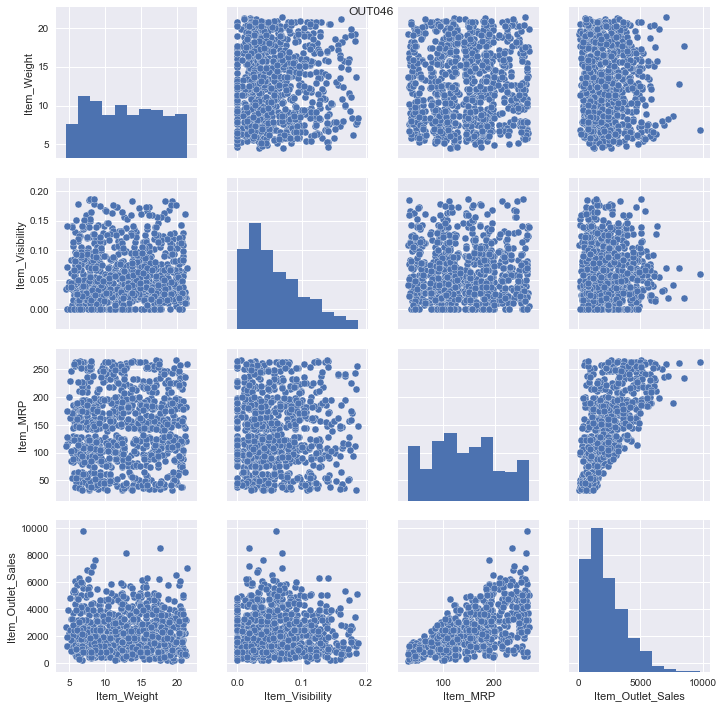

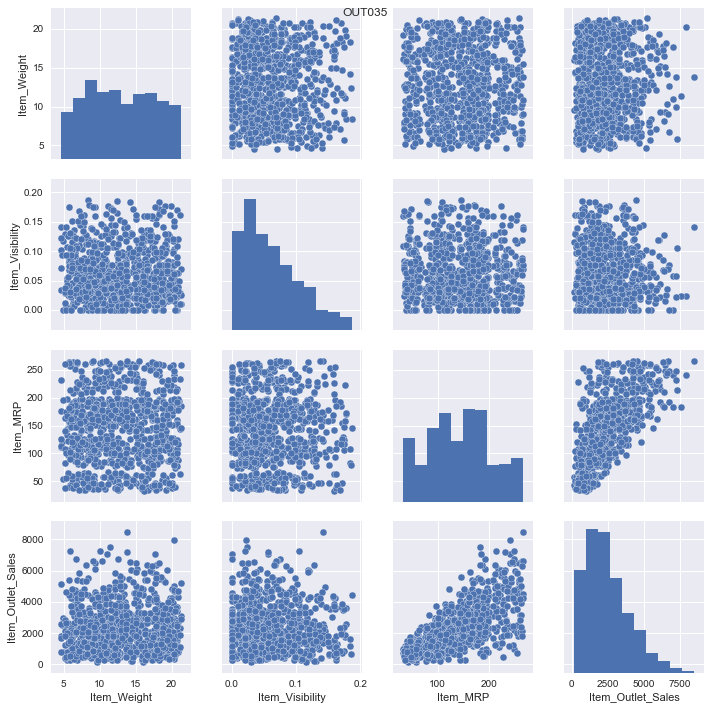

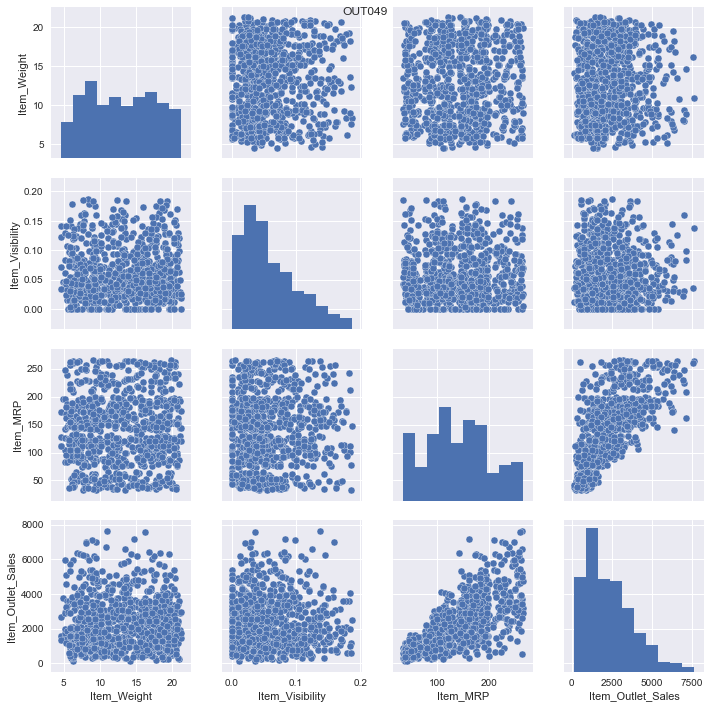

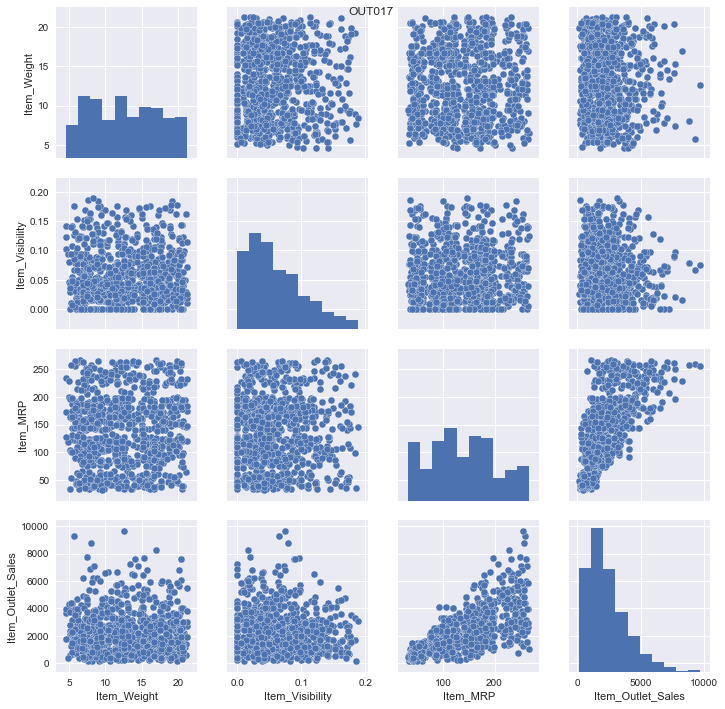

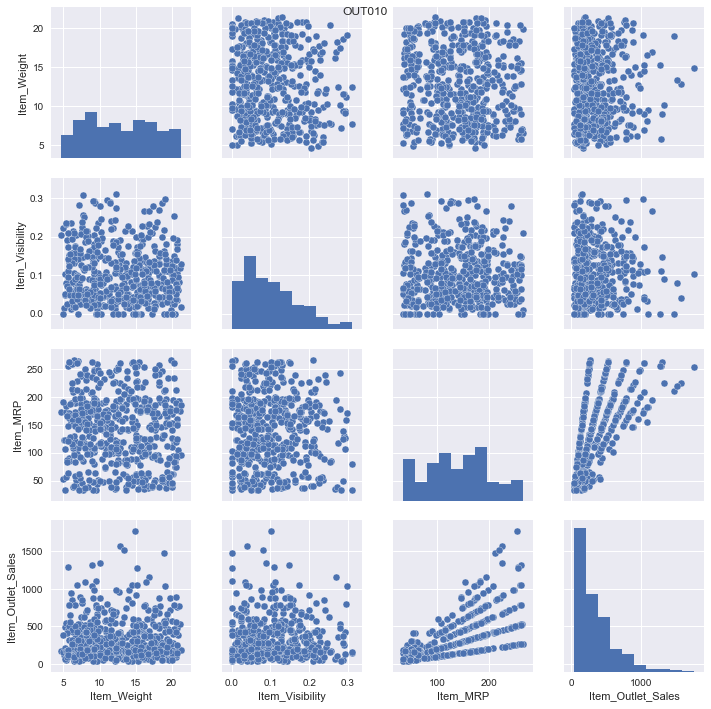

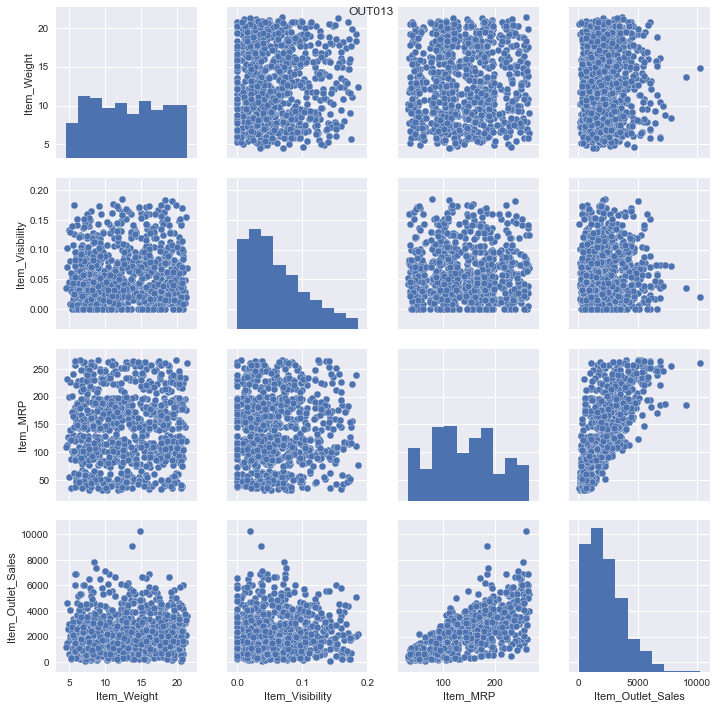

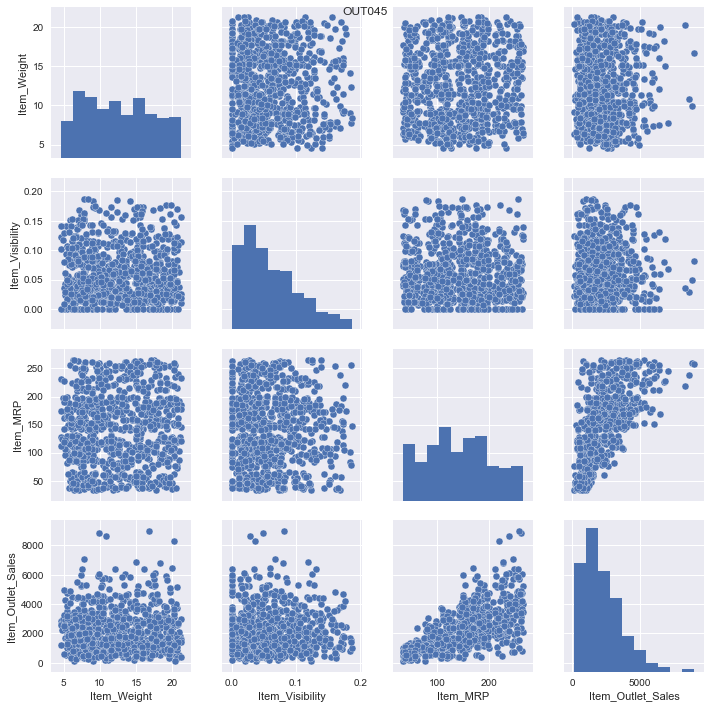

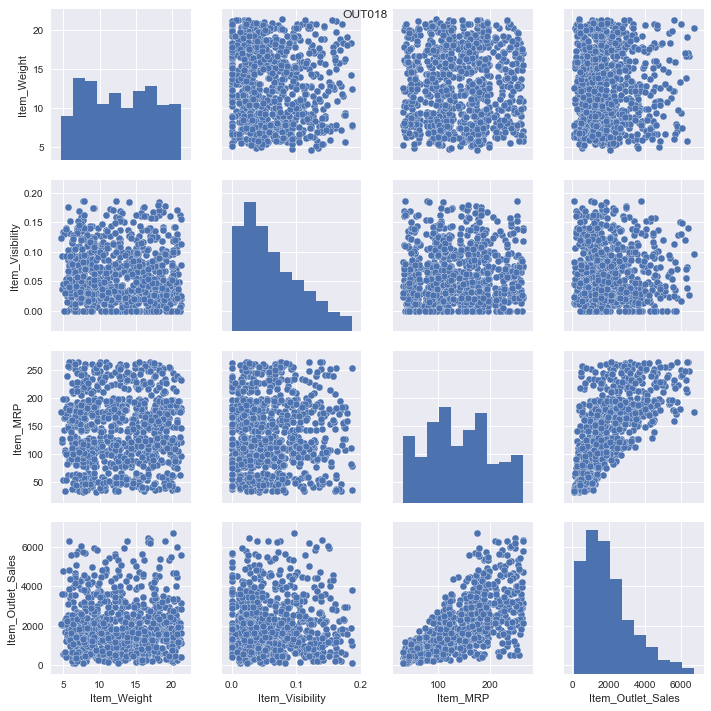

In [65]:
# Bivariate analysis
# we look at the scatter plots across the continuous variables
# it is better to look on an Outlet level
for outlet in bd_df['Outlet_Identifier'].unique().tolist():
    sns.pairplot(bd_df[bd_df.Outlet_Identifier == outlet][cont_col].dropna())
    plt.suptitle(outlet)

# Outlier Detection:

From visually inspecting the statistical description we can see that 'Item_Visibility' and 'Item_Outlet_Sales' have outliers, but we need to know that both of those variables have a skewed distribution, so box plots does not really do justice to these variables.

For now we are not performing any outlier detection and removal

# Feature Engineering:


In [66]:
bd_df.describe()

Item_Visibility     Item_MRP  Outlet_Establishment_Year  \
count      7670.000000  7670.000000                7670.000000   
mean          0.066258   141.231646                1997.876662   
std           0.051589    62.235136                   8.370210   
min           0.000000    31.490000                1985.000000   
25%           0.027077    94.184400                1987.000000   
50%           0.054036   143.215400                1999.000000   
75%           0.094956   185.782550                2004.000000   
max           0.328391   266.888400                2009.000000   

       Item_Outlet_Sales  Item_Weight  
count        7670.000000  7665.000000  
mean         2176.067821    12.851251  
std          1700.873724     4.639454  
min            33.290000     4.555000  
25%           834.913200     8.775000  
50%          1794.331000    12.600000  
75%          3094.638400    16.850000  
max         13086.964800    21.350000

In [67]:
bd_df.head()

Item_Identifier Item_Fat_Content  Item_Visibility              Item_Type  \
0           FDJ40          Regular         0.049349           Frozen Foods   
1           FDU13          Low Fat         0.328391                 Canned   
2           DRE27          Low Fat         0.132671                  Dairy   
3           FDS27          Regular         0.012456                   Meat   
4           FDU44          Regular         0.058143  Fruits and Vegetables   

   Item_MRP Outlet_Identifier  Outlet_Establishment_Year Outlet_Size  \
0  108.6912            OUT027                       1985      Medium   
1  146.0418            OUT019                       1985       Small   
2   96.4726            OUT046                       1997       Small   
3  197.5110            OUT035                       2004       Small   
4  162.1552            OUT027                       1985      Medium   

  Outlet_Location_Type        Outlet_Type  Item_Outlet_Sales  Item_Weight  
0               Tier 3  Supermarket Type3          3057.3536       13.600  
1               Tier 1      Grocery Store           588.5672        8.355  
2               Tier 1  Supermarket Type1           978.7260       11.850  
3               Tier 2  Supermarket Type1          2356.9320       10.195  
4               Tier 3  Supermarket Type3          3086.6488       12.150

In [68]:
# We have to change scale of Item_MRP (normalize)
# Outlet_Establishment_Year - mapping to integers 
# transform non-linear relations into linear relations -- ???
# reduce skewness of distributions of 'Item_Visibility' and 'Item_Outlet_Sales' (square/cube/exponential, to reduce right skewness)
# binning - Item_Weight

In [69]:
# Normalize Item_MRP
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
bd_df['Item_MRP_Scaled'] = min_max_scaler.fit_transform(bd_df['Item_MRP'])

/Users/Kevin/anaconda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/Kevin/anaconda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


---------------------DESCRIPTIVE STATICS Item_MRP_Scaled ---------------------
count: 7670.0
min: 0.0
max: 1.0
mean: 0.466195375593
median: 0.47462259726489225
mode: 0.597082223159
std: 0.264382155605
variance: 0.06989792420226279
25%: 0.266333161143
50%: 0.474622597265
75%: 0.655452840801
NaN_count: 0
NaN_perc: 0.0%
-------------------------------------------------------------
-------------------------------------------------------------


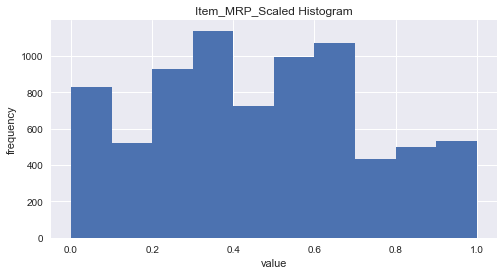

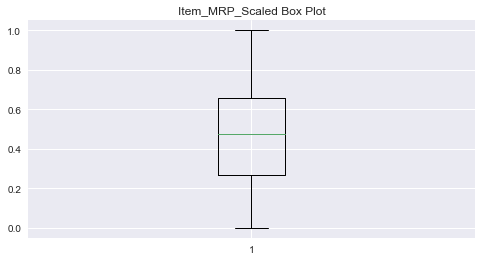

In [70]:
get_continuous_univariate_analysis(bd_df, 'Item_MRP_Scaled')

In [71]:
# Outlet_Establishment_Year - mapping to integers 
bd_df['Outlet_Establishment_Year'].unique()

array([1985, 1997, 2004, 1999, 2007, 1998, 1987, 2002, 2009])

In [72]:
Outlet_Establishment_Year = {1985: 1, 1987: 2, 1997: 3, 1998: 4, 1999: 5, 2002: 6, 
                            2004: 7, 2007: 8, 2009: 9}

In [73]:
bd_df['Outlet_Establishment_Year'].replace(Outlet_Establishment_Year, inplace=True)

In [74]:
bd_df.describe()

Item_Visibility     Item_MRP  Outlet_Establishment_Year  \
count      7670.000000  7670.000000                7670.000000   
mean          0.066258   141.231646                   4.806389   
std           0.051589    62.235136                   2.732177   
min           0.000000    31.490000                   1.000000   
25%           0.027077    94.184400                   2.000000   
50%           0.054036   143.215400                   5.000000   
75%           0.094956   185.782550                   7.000000   
max           0.328391   266.888400                   9.000000   

       Item_Outlet_Sales  Item_Weight  Item_MRP_Scaled  
count        7670.000000  7665.000000      7670.000000  
mean         2176.067821    12.851251         0.466195  
std          1700.873724     4.639454         0.264382  
min            33.290000     4.555000         0.000000  
25%           834.913200     8.775000         0.266333  
50%          1794.331000    12.600000         0.474623  
75%          3094.638400    16.850000         0.655453  
max         13086.964800    21.350000         1.000000

In [75]:
# reduce skewness of distributions of 'Item_Visibility' and 'Item_Outlet_Sales' (square/cube/exponential, to reduce right skewness)
# from the visual representation we can see 'Item_Visibility' should use square root
# and 'Item_Outlet_Sales' should use cube root
# the decision to use square and cube was based on the visual observation of skewness of the variables.
bd_df['Item_Visibility_unskew'] = np.sqrt(bd_df['Item_Visibility'])

In [76]:
bd_df['Item_Outlet_Sales_unskew'] = np.cbrt(bd_df['Item_Outlet_Sales'])

In [77]:
bd_df.head()

Item_Identifier Item_Fat_Content  Item_Visibility              Item_Type  \
0           FDJ40          Regular         0.049349           Frozen Foods   
1           FDU13          Low Fat         0.328391                 Canned   
2           DRE27          Low Fat         0.132671                  Dairy   
3           FDS27          Regular         0.012456                   Meat   
4           FDU44          Regular         0.058143  Fruits and Vegetables   

   Item_MRP Outlet_Identifier  Outlet_Establishment_Year Outlet_Size  \
0  108.6912            OUT027                          1      Medium   
1  146.0418            OUT019                          1       Small   
2   96.4726            OUT046                          3       Small   
3  197.5110            OUT035                          7       Small   
4  162.1552            OUT027                          1      Medium   

  Outlet_Location_Type        Outlet_Type  Item_Outlet_Sales  Item_Weight  \
0               Tier 3  Supermarket Type3          3057.3536       13.600   
1               Tier 1      Grocery Store           588.5672        8.355   
2               Tier 1  Supermarket Type1           978.7260       11.850   
3               Tier 2  Supermarket Type1          2356.9320       10.195   
4               Tier 3  Supermarket Type3          3086.6488       12.150   

   Item_MRP_Scaled  Item_Visibility_unskew  Item_Outlet_Sales_unskew  
0         0.327960                0.222147                 14.513825  
1         0.486629                0.573054                  8.380412  
2         0.276054                0.364240                  9.928578  
3         0.705277                0.111605                 13.308089  
4         0.555081                0.241128                 14.560035

---------------------DESCRIPTIVE STATICS Item_Visibility_unskew ---------------------
count: 7670.0
min: 0.0
max: 0.573054053297
mean: 0.234093883423
median: 0.2324568228443913
mode: 0.0
std: 0.107048836774
variance: 0.01145945345467304
25%: 0.164552142115
50%: 0.232456822844
75%: 0.308149170434
NaN_count: 0
NaN_perc: 0.0%
-------------------------------------------------------------
-------------------------------------------------------------


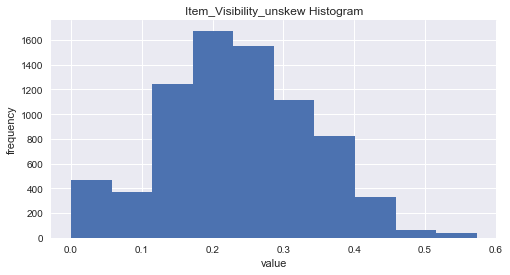

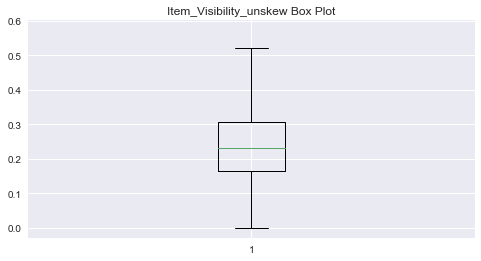

In [78]:
get_continuous_univariate_analysis(bd_df, 'Item_Visibility_unskew')

---------------------DESCRIPTIVE STATICS Item_Outlet_Sales_unskew ---------------------
count: 7670.0
min: 3.21690274815
max: 23.5656620227
mean: 11.9850049487
median: 12.15162018959164
mode: 9.86057167599
std: 3.57410789098
variance: 12.774247216373087
25%: 9.41630338049
50%: 12.1516201896
75%: 14.5725863272
NaN_count: 0
NaN_perc: 0.0%
-------------------------------------------------------------
-------------------------------------------------------------


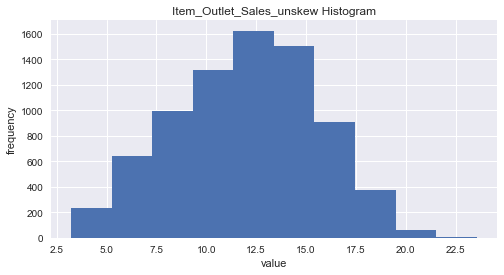

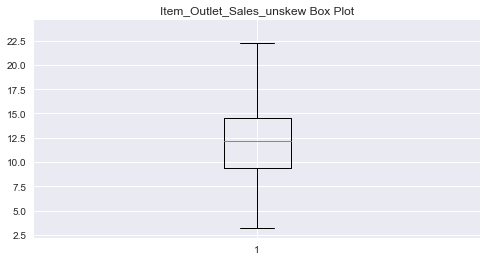

In [79]:
get_continuous_univariate_analysis(bd_df, 'Item_Outlet_Sales_unskew')

In [80]:
# binning - Item_Weight
bd_df['Item_Weight_Cut'] = pd.qcut(bd_df['Item_Weight'], 4, labels=[1,2,3,4])

In [81]:
bd_df.describe()

Item_Visibility     Item_MRP  Outlet_Establishment_Year  \
count      7670.000000  7670.000000                7670.000000   
mean          0.066258   141.231646                   4.806389   
std           0.051589    62.235136                   2.732177   
min           0.000000    31.490000                   1.000000   
25%           0.027077    94.184400                   2.000000   
50%           0.054036   143.215400                   5.000000   
75%           0.094956   185.782550                   7.000000   
max           0.328391   266.888400                   9.000000   

       Item_Outlet_Sales  Item_Weight  Item_MRP_Scaled  \
count        7670.000000  7665.000000      7670.000000   
mean         2176.067821    12.851251         0.466195   
std          1700.873724     4.639454         0.264382   
min            33.290000     4.555000         0.000000   
25%           834.913200     8.775000         0.266333   
50%          1794.331000    12.600000         0.474623   
75%          3094.638400    16.850000         0.655453   
max         13086.964800    21.350000         1.000000   

       Item_Visibility_unskew  Item_Outlet_Sales_unskew  
count             7670.000000               7670.000000  
mean                 0.234094                 11.985005  
std                  0.107049                  3.574108  
min                  0.000000                  3.216903  
25%                  0.164552                  9.416303  
50%                  0.232457                 12.151620  
75%                  0.308149                 14.572586  
max                  0.573054                 23.565662

In [82]:
bd_df.head()

Item_Identifier Item_Fat_Content  Item_Visibility              Item_Type  \
0           FDJ40          Regular         0.049349           Frozen Foods   
1           FDU13          Low Fat         0.328391                 Canned   
2           DRE27          Low Fat         0.132671                  Dairy   
3           FDS27          Regular         0.012456                   Meat   
4           FDU44          Regular         0.058143  Fruits and Vegetables   

   Item_MRP Outlet_Identifier  Outlet_Establishment_Year Outlet_Size  \
0  108.6912            OUT027                          1      Medium   
1  146.0418            OUT019                          1       Small   
2   96.4726            OUT046                          3       Small   
3  197.5110            OUT035                          7       Small   
4  162.1552            OUT027                          1      Medium   

  Outlet_Location_Type        Outlet_Type  Item_Outlet_Sales  Item_Weight  \
0               Tier 3  Supermarket Type3          3057.3536       13.600   
1               Tier 1      Grocery Store           588.5672        8.355   
2               Tier 1  Supermarket Type1           978.7260       11.850   
3               Tier 2  Supermarket Type1          2356.9320       10.195   
4               Tier 3  Supermarket Type3          3086.6488       12.150   

   Item_MRP_Scaled  Item_Visibility_unskew  Item_Outlet_Sales_unskew  \
0         0.327960                0.222147                 14.513825   
1         0.486629                0.573054                  8.380412   
2         0.276054                0.364240                  9.928578   
3         0.705277                0.111605                 13.308089   
4         0.555081                0.241128                 14.560035   

  Item_Weight_Cut  
0               3  
1               1  
2               2  
3               2  
4               2

# Model Building:
    Now that the EDA process has been complete we start off with the model building pipeline

In [ ]:
# split into train validation sets,
# this should have 